# Deep Q-Network for Cart-Pole.

In this assignment you are required to implement a Deep Q-Network agent, for the Cart-Pole problem. 

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent. 


**Submission:**

Daniel Shalam - 205745052,
Noy boutboul - 2067282691

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [2]:
!pip install stable-baselines3[extra] ale-py==0.7.4
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


## Cart Pole

In this environment a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The observation consists of the cart position, cart velocity, pole angle and pole angular velocity.

There are 2 actions corresponding to moving the cart to the left and to the right. 

See full description [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).



In [4]:
ENV_NAME = "CartPole-v0"

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

observation dim (4,) number of actions 2


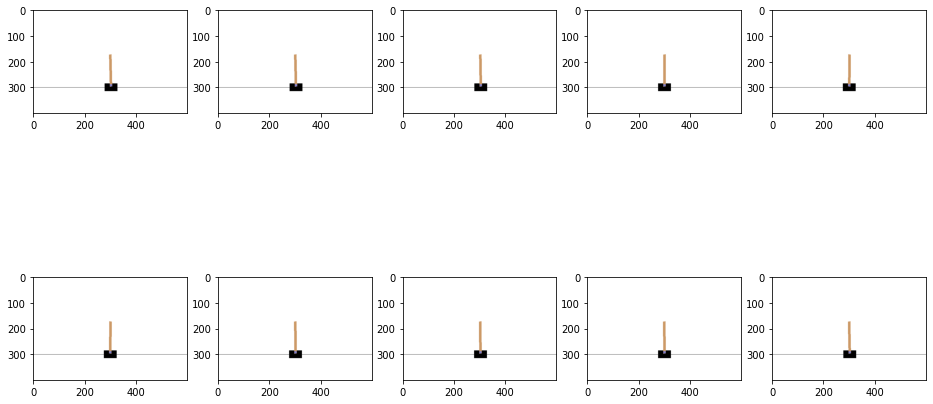

In [5]:
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes. 

In [6]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions

    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,)) 

In [7]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Video generation

In [8]:
# run sessions

import gym.wrappers    
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

n_games = 1 # how many games to record

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=3, greedy=False) for _ in range(10)]


In [9]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Assignment

Implement a DQN agent that contains:
1. A nerual network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent. 

In [10]:
import torch
from torch import nn
import math
from itertools import count
from collections import namedtuple, deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Replay buffer and decay epsilon scheduler

In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'gamma', 'next_state'))

class ReplayBuffer(object):
    """
    implementation of replay buffer
    """
    def __init__(self):
      self._buffer = []
      self._length = 0
    
    def reset(self):
      """ 
      Reset the buffer. 
      """
      self._buffer = []
      self._length = 0

    def sample_transitions(self, n_samples: int = 1):
      """ 
      Ramdomly sample transition from the buffer. 
      """
      return random.sample(self._buffer, n_samples)

    def append(self, *args):
      """ 
      Add transition into the buffer. 
      """
      self._buffer.append(Transition(*args))
      self._length += 1
    
    def __len__(self):
      return len(self._buffer)


class EpsilonDecayScheduler:
  """
  implementation of decaying epsilon scheduler
  """
  def __init__(self, epsilon_start=0.9, epislon_end=0.05, decaying_rate=1000):
      self.eps_start = epsilon_start  # epsilon start value
      self.eps_end = epislon_end      # epsilon end value
      self.decay_rate = decaying_rate # controls the rate of exponential decay of epsilon, higher means a slower decay
      self.step_count = 0
      self.last_threshold = None
  
  def step(self, increment_step: bool = True):
      eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.step_count / self.decay_rate)
      if increment_step:
        self.step_count += 1
      self.last_threshold = eps_threshold
      return eps_threshold


##The Deep Q-Network

In [12]:
class DQN(nn.Module):
    """
    implementation of DQN
    """
    def __init__(self, obs_dim, n_actions, dims_mlp, activation: str = 'relu'):
        super(DQN, self).__init__()
        # input is a 4 dimensional vector
        self.n_actions = n_actions
        self.obs_dim = obs_dim
        if isinstance(obs_dim, tuple):
          self.obs_dim = self.obs_dim[0]
          
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()

        self.mlp = self._build_network(dims_mlp)
        return

    def _build_network(self, dims_mlp):
        """
        Build network using a list of dimensions
        """
        if isinstance(dims_mlp, int):
            dims_mlp = [dims_mlp]

        dims = [self.obs_dim] + dims_mlp
        mlp = []
        for i in range(len(dims[:-1])):
            mlp += [nn.Linear(dims[i], dims[i+1]), self.activation]
        # last layer
        mlp += [nn.Linear(dims_mlp[-1], self.n_actions)]

        return nn.Sequential(*mlp)

    def forward(self, x):
        return self.mlp(x)

##Agent

In [13]:
class DQNAgent:
    """
    implementation of Agent
    """
    def __init__(self, obs_dim, n_actions, dim_mlp, activation: str = 'relu'):
        self.n_actions = n_actions
        self.q_net = DQN(obs_dim, n_actions, dim_mlp, activation).to(device)
        self.target_q_net = DQN(obs_dim, n_actions, dim_mlp, activation).to(device)
        # load policy params into target network
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        # define optimizer
        self.optimizer = torch.optim.AdamW(self.q_net.parameters(), lr=LR, amsgrad=True)

        print(f"Agent intiailized. obs_dim {obs_dim}, n_actions={n_actions}")

    def predict_qvalues(self, states):
        """
        Return predicted Q values using policy network
        """
        q_values = self.q_net(states)
        return q_values

    @torch.no_grad()
    def predict_target_qvalues(self, states):
        """
        Return predicted Q values using target policy network
        """
        q_values = self.target_q_net(states)
        return q_values

    def sample_action(self, state, eps_threshold):
        """
        Sample action according to epsilon
        """
        if random.random() > eps_threshold:
            with torch.no_grad():
                return self.q_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    
    def train_q_network(self, replay_buffer):
        """
        Train policy network
        """
        if BATCH_SIZE > len(replay_buffer):
          # if we dont have sufficent experience
          return

        # transitions are of shape [S, A, R, G, S_NEXT]
        transitions = replay_buffer.sample_transitions(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # unpack transitions and mask done next states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        gamma_batch = torch.cat(batch.gamma)
        
        # predict q-values with policy network
        state_action_values = self.predict_qvalues(state_batch).gather(1, action_batch)

        # predict target q-values for each (next) state and take it's max
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = self.predict_target_qvalues(non_final_next_states).max(1)[0]

        # Compute the temporal target
        temporal_target = (next_state_values * gamma_batch) + reward_batch

        # loss is the TD-error
        loss = criterion(state_action_values, temporal_target.unsqueeze(-1))

        # backward
        self.optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_value_(self.q_net.parameters(), MAX_GRAD_NORM)
        self.optimizer.step()

        return loss.mean().item()

    def update_target_weights(self):
      """
      Soft update to target network parameters by: θ′ ← τθ + (1−τ)θ′
      """
      target_net_state_dict = self.target_q_net.state_dict()
      policy_net_state_dict = self.q_net.state_dict()
      for key in policy_net_state_dict:
          target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
      self.target_q_net.load_state_dict(target_net_state_dict)


## Hyper parameters


In [14]:
NUM_EPISODES = 400
LR = 1e-3
BATCH_SIZE = 64     # number of transitions sampled from the replay buffer
GAMMA = 0.99        # discount factor
TAU = 0.005         # the update rate of the target network
MAX_GRAD_NORM = 100 # apply gradient clipping on this norm
dims_mlp = [128]    # dqn hidden layers
activation = 'relu' # dqn activation

obs = env.reset()
n_actions = env.action_space.n
obs_dim = obs.shape
criterion = nn.SmoothL1Loss()

In [17]:
results = {
    "loss": np.zeros(NUM_EPISODES),
    "reward": np.zeros(NUM_EPISODES), 
    "duration": np.zeros(NUM_EPISODES),
    "count": np.zeros(NUM_EPISODES),
    "epsilon": np.zeros(NUM_EPISODES),
}
gamma_not_done = torch.tensor([GAMMA], device=device)
gamma_done = torch.tensor([0], device=device)

dqn_agent = DQNAgent(obs_dim, n_actions, dims_mlp, activation)
replay_buffer = ReplayBuffer()
eps_scheduler = EpsilonDecayScheduler()

# training loop
print("Start training...")
for episode in range(NUM_EPISODES):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for c in count():
      # epsilon scheduler step
      eps_threshold = eps_scheduler.step()

      # sampling action and perform enviorement step
      action = dqn_agent.sample_action(state, eps_threshold)
      obs, reward, done, _ = env.step(action.item())
      reward = torch.tensor([reward], device=device)

      # add experience to replay buffer and move to the next state
      if done:
        next_state = None
        gamma = gamma_done
      else:
        next_state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        gamma = gamma_not_done

      replay_buffer.append(state, action, reward, gamma, next_state)
      state = next_state

      # train agent
      loss = dqn_agent.train_q_network(replay_buffer)

      # update of the target network's weights
      dqn_agent.update_target_weights()

      if loss is not None:
        results["loss"][episode] += loss
        results["reward"][episode] += reward.item()
        results["count"][episode] += 1

      if done:
        break

    results["duration"][episode] = c + 1
    # plot only the last epsilon of each episode
    results["epsilon"][episode] = eps_threshold

    if (episode + 1) % 50 == 0:
      avg_loss = results["loss"][episode] / results["count"][episode]
      reward = results["reward"][episode]
      print(f"Episode: {episode+1}/{NUM_EPISODES}, Avg Loss: {avg_loss:.4f}, Total Reward: {reward}, Duration: {c}")

torch.save(dqn_agent.q_net.state_dict(), './checkpoint_last.pth')
print("Done training")

Agent intiailized. obs_dim (4,), n_actions=2
Start training...
Episode: 50/400, Avg Loss: 0.1556, Total Reward: 15.0, Duration: 14
Episode: 100/400, Avg Loss: 0.3118, Total Reward: 122.0, Duration: 121
Episode: 150/400, Avg Loss: 0.5077, Total Reward: 150.0, Duration: 149
Episode: 200/400, Avg Loss: 0.6266, Total Reward: 145.0, Duration: 144
Episode: 250/400, Avg Loss: 0.6302, Total Reward: 137.0, Duration: 136
Episode: 300/400, Avg Loss: 0.6712, Total Reward: 132.0, Duration: 131
Episode: 350/400, Avg Loss: 0.5958, Total Reward: 200.0, Duration: 199
Episode: 400/400, Avg Loss: 0.7057, Total Reward: 200.0, Duration: 199
Done training


##Generate training plots

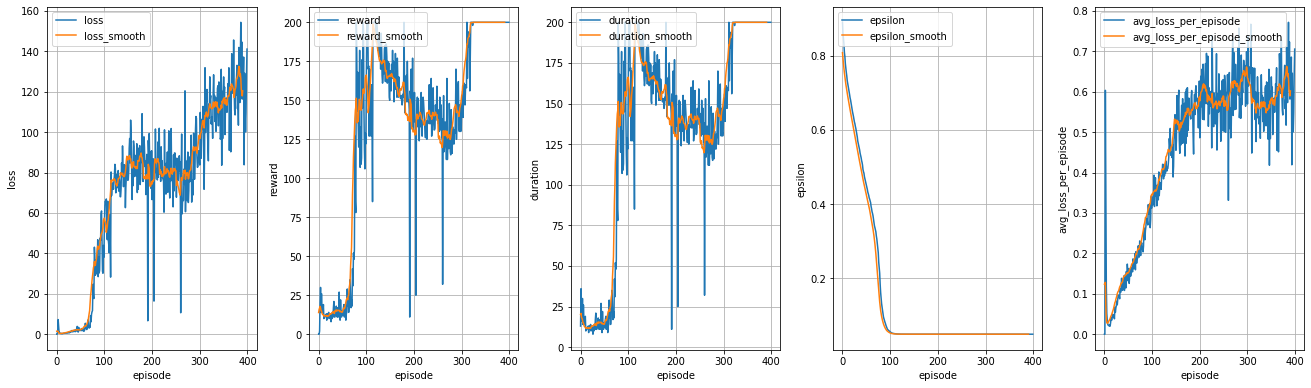

In [23]:
def moving_average(x, window_width=10):
    """
    Function to smooth array values using moving average
    """
    cumsum_vec = np.cumsum(np.insert(x, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec

def plot_results(results_dict, figure_size=(18.5, 5.5)):
    """ 
    Plot results 
    """
    metrics = [m for m in results_dict.keys() if m not in ["count", "avg_reward_per_episode"]]
    n_cols = min(4, len(metrics))
    n_rows = 1 if len(metrics) <= 4 else math.floor(len(metrics) / n_cols)
    fig, axes = plt.subplots(1, len(metrics))
    fig.set_size_inches(figure_size)

    if len(metrics) == 1:
      axes = [axes]

    for i, metric in enumerate(list(metrics)):
        res = results_dict[metric]
        res_smooth = moving_average(res.copy())

        axes[i].plot(res, label=metric)
        axes[i].plot(res_smooth, label=f"{metric}_smooth")

        axes[i].set_xlabel('episode')
        axes[i].set_ylabel(metric)
        axes[i].grid()
        axes[i].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

counts = results["count"]
counts[counts == 0] = 1
results["avg_loss_per_episode"] = results["loss"] / counts
plot_results(results)

##Evaluate and generate video

In [19]:
@torch.no_grad()
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
            if greedy:
              action = agent.predict_qvalues(s).argmax(axis=-1)[0]
            else:
              action = agent.sample_action(s, eps_scheduler.last_threshold)[0]

            s, r, done, _ = env.step(action.item())
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

mean_reward = evaluate(env, dqn_agent, greedy=True, n_games=5)
print("Evaluation Avg reward:", mean_reward)

Evaluation Avg reward: 200.0


In [20]:
n_games = 1 # how many games to record

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, dqn_agent, n_games=n_games, greedy=True) for _ in range(1)]

In [21]:
# show video
video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))